## Feature extraction
##### This note book is for getting features

In [1]:
import os
import sklearn
import numpy as np
import pandas as pd
from glob import glob
import scipy.io as sio
import matplotlib.pyplot as plt
import neurokit2 as nk

In [2]:
training_data_dir = "training/"
training_data_path = glob(training_data_dir+"*mat")
training_path_id_dic = { x.split('/')[-1].split('.')[0] : x for x in training_data_path}

reference = pd.read_csv(training_data_dir+"REFERENCE.csv",header=None)
reference = reference.rename(columns={0:'id',1:"label"})
reference_dic = dict(zip(reference['id'].to_list(),reference['label'].to_list() ) )

meta_pd = pd.DataFrame(columns=["id","path","label"])
meta_pd['id'] = training_path_id_dic.keys()
meta_pd['path'] = meta_pd['id'].map( training_path_id_dic.get )
meta_pd['label'] = meta_pd['id'].map(  reference_dic.get )
meta_pd['encoded_label'] = pd.Categorical(meta_pd['label']).codes


def get_mat(mat_path):
    s = sio.loadmat(mat_path)
    return s['val'][0]

meta_pd['data'] = meta_pd['path'].map( get_mat )
meta_pd['length'] = meta_pd['data'].map( np.shape )





import warnings
warnings.filterwarnings("ignore")
def data_len_norm(meta):
    '''
    Normalize the lengh of data follwing the idea from paper:
    https://res.mdpi.com/d_attachment/sensors/sensors-20-02136/article_deploy/sensors-20-02136.pdf
    
    Args:

        meta: pd.Dataframe, meta date in pd form.
    
    return:
        re: meta data after  processing
    
    '''
   
  
    
    re_pd = meta.copy()
    #print(len(re_pd))
    n = 0
    for row in re_pd.iterrows():
        if row[1]['length'][0] > 9000:
            adding_list = cut_recording(row[1]['data'])
            re_pd = re_pd.drop(row[0])
            for n in adding_list:
                new_recording = meta.iloc[row[0]].copy()
                new_recording['data'] = n
                new_recording['id'] = 'extra_'+new_recording['id']
                new_recording['length'] = 9000
                # print(new_recording)
                re_pd = re_pd.append(new_recording,ignore_index = True)
                n+=1
               

            
      
        if row[1]['length'][0] < 9000:
            pass

    print(n)
    return re_pd


LENGTH_THRESHOLD = 9000


def cut_recording(ecg:np.array,length_threshold=9000):
    len_overlap = int(0.5*length_threshold)
    start = 0
    end = 9000
    re = []
    re.append(ecg[start:end])
    while True:
        if end+len_overlap > len(ecg):
            re.append(ecg[-9000:])
            break
        re.append(ecg[start+len_overlap:end+len_overlap])
        start +=len_overlap
        end+= len_overlap
        
        
    # print(ecg)
    
   
    return re


meta_pd = data_len_norm(meta_pd)
# meta_pd['length'] = meta_pd['length'].values()

[ 54  61  67 ... 118 130  97]


In [3]:
def preprocess(meta=meta_pd,to_path='precessed_data/normalized/',func_list=[],store = False):
    '''
    Perfrom the preprocessing to the data from given path and store the precessed data in given path
    
    Args:
        meta: like meta_pd which we created before
        from_path:  path contains *.mat data
        to_path: path where store the precessed data in npy form 
        func_list : aprroaches , which will be performed on the data.Notice that,  the approaches will be performed in given ordering
        store: bool, True to store the data, False for only return tmp_data
    return:
    '''
    # tmp_meta = pd.DataFrame()
    # tmp_meta['id'] = meta['id']
    
    tmp_meta = meta.copy()
    tmp_meta['to_path'] = to_path + meta['id']+'.npy'

    tmp_meta['preprocessed_data'] = meta['data']
    tmp_meta['preprocessed_data_wo_fft'] = meta['data']
    for f in func_list:
        tmp_meta['preprocessed_data'] = tmp_meta['preprocessed_data'].map(f)
        # if f != ecg_fourier:
        #     tmp_meta['preprocessed_data_wo_fft'] = tmp_meta['preprocessed_data_wo_fft'].map(f)

  
    if store==True:
        for path,array in zip( tmp_meta['to_path'].to_list(),tmp_meta['preprocessed_data'].to_list()[0]):
            np.save( path,array  )
    
    
    #print(tmp_meta.head())
    return tmp_meta

def ecg_len_norm( ecg_np ):
    '''
    Be used in preprocess() to make the length be 9000 (over 9000 then cut, under 9000 then repeat)
    
    Args:
        ecg_np: ecg data in np.array form in shape of (N,)
    
    return:
        re: processed data in array form
    
    '''
    if len(ecg_np) < 9000:
        re = np.pad(ecg_np , (0,9000-ecg_np.shape[0]),  'wrap')
    elif len(ecg_np) >9000 :
        re = ecg_np[:9000]
        # print(len(ecg_np))
    else :
        re = ecg_np

    
    return re
meta_pd = preprocess(meta=meta_pd,func_list=[ecg_len_norm])

In [4]:
# # meta_pd.columns
# for i in meta_pd['preprocessed_data']:
#     print(len(i))

### Statistical features

for i in meta_pd['data']:
    print(i)

In [5]:
# meta_pd['mean'] = meta_pd['data'].map( np.mean )
# meta_pd['std'] = meta_pd['data'].map( np.std )
# meta_pd['length'] = meta_pd['data'].map( np.shape )
fs = 300

In [6]:
## get cleaned data
meta_pd['clean'] = meta_pd['preprocessed_data'].apply(nk.ecg_clean,sampling_rate = fs)
meta_pd.head()

,id,path,label,encoded_label,data,length,to_path,preprocessed_data,preprocessed_data_wo_fft,clean
0,train_ecg_01607,training/train_ecg_01607.mat,N,1,"[533, 646, 751, 856, 950, 986, 978, 931, 901, ...","(4772,)",precessed_data/normalized/train_ecg_01607.npy,"[533, 646, 751, 856, 950, 986, 978, 931, 901, ...","[533, 646, 751, 856, 950, 986, 978, 931, 901, ...","[110.15929360106207, 208.67480497541152, 299.3..."
1,train_ecg_05917,training/train_ecg_05917.mat,N,1,"[618, 735, 862, 988, 1092, 1141, 1143, 1122, 1...","(9000,)",precessed_data/normalized/train_ecg_05917.npy,"[618, 735, 862, 988, 1092, 1141, 1143, 1122, 1...","[618, 735, 862, 988, 1092, 1141, 1143, 1122, 1...","[233.54514911611267, 344.0053727692085, 447.44..."
2,train_ecg_05509,training/train_ecg_05509.mat,O,2,"[6, 5, 4, 4, 4, 3, 3, 2, 1, 1, 0, 0, -1, -2, -...","(7076,)",precessed_data/normalized/train_ecg_05509.npy,"[6, 5, 4, 4, 4, 3, 3, 2, 1, 1, 0, 0, -1, -2, -...","[6, 5, 4, 4, 4, 3, 3, 2, 1, 1, 0, 0, -1, -2, -...","[-3.7659657176220196, -4.399926844847255, -5.0..."
3,train_ecg_00573,training/train_ecg_00573.mat,N,1,"[-913, -1097, -1286, -1469, -1630, -1720, -175...","(9000,)",precessed_data/normalized/train_ecg_00573.npy,"[-913, -1097, -1286, -1469, -1630, -1720, -175...","[-913, -1097, -1286, -1469, -1630, -1720, -175...","[-590.164542602203, -762.0313773115372, -925.1..."
4,train_ecg_01354,training/train_ecg_01354.mat,N,1,"[-683, -844, -1018, -1196, -1354, -1450, -1483...","(9000,)",precessed_data/normalized/train_ecg_01354.npy,"[-683, -844, -1018, -1196, -1354, -1450, -1483...","[-683, -844, -1018, -1196, -1354, -1450, -1483...","[-545.4953972112104, -702.7603422554172, -852...."


In [7]:
## get mean, std, min, max of cleaned data
meta_pd['clean_mean'] = meta_pd['clean'].apply(np.mean)
meta_pd['clean_std'] = meta_pd['clean'].apply(np.std)
meta_pd['clean_max'] = meta_pd['clean'].apply(np.max)
meta_pd['clean_min'] = meta_pd['clean'].apply(np.min)

## get the distance between max and min
meta_pd['clean_dist'] =meta_pd['clean_max']-meta_pd['clean_min']
meta_pd['clean_dist'] = meta_pd['clean_dist'].apply(np.abs)
meta_pd.head()

,id,path,label,encoded_label,data,length,to_path,preprocessed_data,preprocessed_data_wo_fft,clean,clean_mean,clean_std,clean_max,clean_min,clean_dist
0,train_ecg_01607,training/train_ecg_01607.mat,N,1,"[533, 646, 751, 856, 950, 986, 978, 931, 901, ...","(4772,)",precessed_data/normalized/train_ecg_01607.npy,"[533, 646, 751, 856, 950, 986, 978, 931, 901, ...","[533, 646, 751, 856, 950, 986, 978, 931, 901, ...","[110.15929360106207, 208.67480497541152, 299.3...",0.512616,303.523427,932.440509,-1382.471238,2314.911747
1,train_ecg_05917,training/train_ecg_05917.mat,N,1,"[618, 735, 862, 988, 1092, 1141, 1143, 1122, 1...","(9000,)",precessed_data/normalized/train_ecg_05917.npy,"[618, 735, 862, 988, 1092, 1141, 1143, 1122, 1...","[618, 735, 862, 988, 1092, 1141, 1143, 1122, 1...","[233.54514911611267, 344.0053727692085, 447.44...",2.945595,95.721186,733.599473,-401.446635,1135.046109
2,train_ecg_05509,training/train_ecg_05509.mat,O,2,"[6, 5, 4, 4, 4, 3, 3, 2, 1, 1, 0, 0, -1, -2, -...","(7076,)",precessed_data/normalized/train_ecg_05509.npy,"[6, 5, 4, 4, 4, 3, 3, 2, 1, 1, 0, 0, -1, -2, -...","[6, 5, 4, 4, 4, 3, 3, 2, 1, 1, 0, 0, -1, -2, -...","[-3.7659657176220196, -4.399926844847255, -5.0...",-0.091193,104.151607,824.764217,-151.663999,976.428215
3,train_ecg_00573,training/train_ecg_00573.mat,N,1,"[-913, -1097, -1286, -1469, -1630, -1720, -175...","(9000,)",precessed_data/normalized/train_ecg_00573.npy,"[-913, -1097, -1286, -1469, -1630, -1720, -175...","[-913, -1097, -1286, -1469, -1630, -1720, -175...","[-590.164542602203, -762.0313773115372, -925.1...",-5.290361,421.975935,2583.005689,-6655.281730,9238.287419
4,train_ecg_01354,training/train_ecg_01354.mat,N,1,"[-683, -844, -1018, -1196, -1354, -1450, -1483...","(9000,)",precessed_data/normalized/train_ecg_01354.npy,"[-683, -844, -1018, -1196, -1354, -1450, -1483...","[-683, -844, -1018, -1196, -1354, -1450, -1483...","[-545.4953972112104, -702.7603422554172, -852....",-0.989111,323.551456,2121.935571,-1841.218353,3963.153924


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


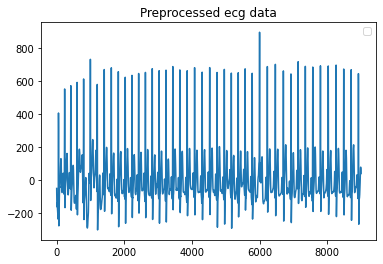

In [78]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer()
cleaned_ecg = meta_pd.iloc[9]['clean']
# sing, info = nk.ecg_peaks(cleaned_ecg, sampling_rate=300)
# epochs = nk.ecg_segment(cleaned_ecg, rpeaks=None, sampling_rate=224, show=True)
# print(epochs['1'])
# np.isnan(epochs['3']['Signal'].values)
# print(len(epochs))
# for i in range(5):
#     cleaned_ecg = meta_pd.iloc[i+100]['clean']
   
#     print(meta_pd.iloc[i+100][['id','label']])
#     _, rpeaks = nk.ecg_peaks(cleaned_ecg.reshape(9000), sampling_rate=300, correct_artifacts=True,method='promac')
#     # 
#     epochs = nk.ecg_segment(cleaned_ecg, rpeaks=rpeaks["ECG_R_Peaks"], sampling_rate=300,show=True)    

#     #epochs = nk.ecg_segment(cleaned_ecg, rpeaks=None, sampling_rate=300, show=True)
#     l = len(epochs['1']['Signal'].values)
#     a = np.zeros([1,l])
#     for i in epochs.values():
#         if True in np.isnan(i['Signal'].values):
#             # print(i)
#             pass
#         else:
#             #print(len(i['Signal'].values))
#             a += transformer.fit_transform(i['Signal'].values.reshape(1, -1)) 
#         #print(i['Signal'].values)
#     # print(len(a))
#     # print(a)

#     a = transformer.fit_transform(a.reshape(1,-1))
#     plt.figure()
#     plt.plot(range(l),a.reshape(l) ,'ro')


#     plt.show()

cleaned_ecg = meta_pd[meta_pd['id']=='train_ecg_01553']['clean'].values[0]
plt.title("Preprocessed ecg data")
plt.plot(range(9000),cleaned_ecg,)
plt.legend()

In [59]:
# 

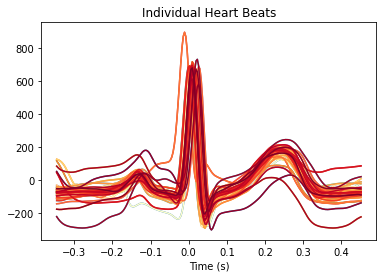

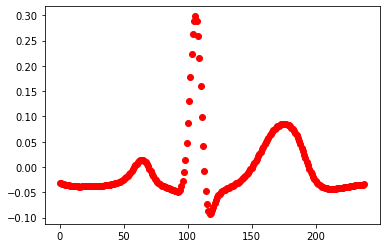

In [63]:
cleaned_ecg = meta_pd[meta_pd['id']=='train_ecg_01553']['clean'].values[0]
_, rpeaks = nk.ecg_peaks(cleaned_ecg.reshape(9000), sampling_rate=300, correct_artifacts=True,method='promac')
    # 
epochs = nk.ecg_segment(cleaned_ecg, rpeaks=rpeaks["ECG_R_Peaks"], sampling_rate=300, show=True)  
l = len(epochs['1']['Signal'].values)
a = np.zeros([1,l])

for i in epochs.values():
    if True in np.isnan(i['Signal'].values):
            # print(i)
        pass
    else:
            #print(len(i['Signal'].values))
        a += transformer.fit_transform(i['Signal'].values.reshape(1, -1)) 
        #print(i['Signal'].values)
    # print(len(a))
    # print(a)

a = transformer.fit_transform(a.reshape(1,-1))
plt.figure()
plt.plot(range(l),a.reshape(l) ,'ro')


plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['gamboa error: index -1 is out of bounds for axis 0 with size 0']
(239,)


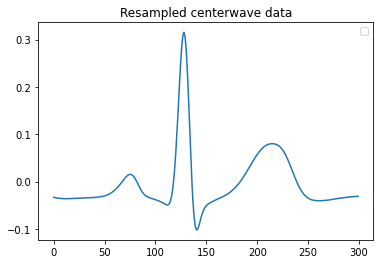

In [79]:
def get_segment(ecg_np):
    '''
    
    Args:
        ecg_np: np.array, cleaned ecg data, (9000)
    

    Return:
        Segment: np.array, 
    '''
    ecg_np = transformer.fit_transform(ecg_np.reshape(1, -1)).reshape(9000)
    _, rpeaks = nk.ecg_peaks(ecg_np.reshape(9000), sampling_rate=300, correct_artifacts=True,method='promac')
    # elgendi2010,
    epochs = nk.ecg_segment(ecg_np, rpeaks=rpeaks["ECG_R_Peaks"], sampling_rate=300)
    seg_len = len(epochs['1']['Signal'].values)
    seg = np.zeros([1,seg_len])
    for i in epochs.values():
        if True in np.isnan(i['Signal'].values):
            pass
        else:
            seg += transformer.fit_transform(i['Signal'].values.reshape(1, -1)) 


    seg = transformer.fit_transform(seg.reshape(1,-1))
    return seg.reshape(seg_len)

from scipy import signal

cleaned_ecg = meta_pd.iloc[154]['clean']
cleaned_ecg = meta_pd[meta_pd['id']=='train_ecg_01553']['clean'].values[0]

seg_test =  get_segment(cleaned_ecg)
seg_resample = signal.resample(seg_test, 300)
print(seg_test.shape)
plt.figure()
#plt.plot(range(seg_test.shape[0]),seg_test.reshape(seg_test.shape[0]) ,'ro')
plt.title("Resampled centerwave data")
plt.plot(range(seg_resample.shape[0]),seg_resample.reshape(seg_resample.shape[0]) )
plt.legend()


plt.show()



In [ ]:
meta_pd.columns
meta_pd['seg'] = meta_pd['clean'].map(get_segment)
meta_pd.head()
# Nan in the clean data! TODO: np.NaN or 'NaN'?

# for i,r in enumerate(meta_pd['clean']):
#     # if True in np.isnan(r):
#     #     print(r)
#     #print(r) # [-116]
#     print(i)
#     get_segment(r)


In [ ]:
# 
meta_pd['seg_len'] = meta_pd['seg'].map(len)
np.min(meta_pd['seg_len'])

149

In [ ]:
# seg_resample = signal.resample(seg_test, 300)

meta_pd['seg_norm'] = meta_pd['seg'].apply(signal.resample,num=300)
meta_pd['clean_std'] = meta_pd['clean_std'].map(np.round)
meta_pd.head()

,id,path,label,encoded_label,data,length,to_path,preprocessed_data,preprocessed_data_wo_fft,clean,clean_mean,clean_std,clean_max,clean_min,clean_dist,seg,seg_len,seg_norm
0,train_ecg_01607,training/train_ecg_01607.mat,N,1,"[533, 646, 751, 856, 950, 986, 978, 931, 901, ...","(4772,)",precessed_data/normalized/train_ecg_01607.npy,"[533, 646, 751, 856, 950, 986, 978, 931, 901, ...","[533, 646, 751, 856, 950, 986, 978, 931, 901, ...","[110.15929360106207, 208.67480497541152, 299.3...",0.512616,304.0,932.440509,-1382.471238,2314.911747,"[0.06297485785137716, 0.06102615827983399, 0.0...",212,"[0.06297485785137714, 0.06714753397880835, 0.0..."
1,train_ecg_05917,training/train_ecg_05917.mat,N,1,"[618, 735, 862, 988, 1092, 1141, 1143, 1122, 1...","(9000,)",precessed_data/normalized/train_ecg_05917.npy,"[618, 735, 862, 988, 1092, 1141, 1143, 1122, 1...","[618, 735, 862, 988, 1092, 1141, 1143, 1122, 1...","[233.54514911611267, 344.0053727692085, 447.44...",2.945595,96.0,733.599473,-401.446635,1135.046109,"[-0.03192336962521823, -0.03225376247207021, -...",200,"[-0.031923369625218245, -0.03329842531574885, ..."
2,train_ecg_05509,training/train_ecg_05509.mat,O,2,"[6, 5, 4, 4, 4, 3, 3, 2, 1, 1, 0, 0, -1, -2, -...","(7076,)",precessed_data/normalized/train_ecg_05509.npy,"[6, 5, 4, 4, 4, 3, 3, 2, 1, 1, 0, 0, -1, -2, -...","[6, 5, 4, 4, 4, 3, 3, 2, 1, 1, 0, 0, -1, -2, -...","[-3.7659657176220196, -4.399926844847255, -5.0...",-0.091193,104.0,824.764217,-151.663999,976.428215,"[0.0017980411535852643, 0.0018279522510279643,...",332,"[0.0030134983017627917, 0.0013812406997324393,..."
3,train_ecg_00573,training/train_ecg_00573.mat,N,1,"[-913, -1097, -1286, -1469, -1630, -1720, -175...","(9000,)",precessed_data/normalized/train_ecg_00573.npy,"[-913, -1097, -1286, -1469, -1630, -1720, -175...","[-913, -1097, -1286, -1469, -1630, -1720, -175...","[-590.164542602203, -762.0313773115372, -925.1...",-5.290361,422.0,2583.005689,-6655.281730,9238.287419,"[-0.06058881110694523, -0.06066300857073702, -...",241,"[-0.06058881110694526, -0.0640021474884407, -0..."
4,train_ecg_01354,training/train_ecg_01354.mat,N,1,"[-683, -844, -1018, -1196, -1354, -1450, -1483...","(9000,)",precessed_data/normalized/train_ecg_01354.npy,"[-683, -844, -1018, -1196, -1354, -1450, -1483...","[-683, -844, -1018, -1196, -1354, -1450, -1483...","[-545.4953972112104, -702.7603422554172, -852....",-0.989111,324.0,2121.935571,-1841.218353,3963.153924,"[-0.03710982861601833, -0.036662277448818954, ...",215,"[-0.03710982861601835, -0.035582535056627305, ..."


In [ ]:
print(len(r))
# get_segment(r)
# nk.signal_rate = 
_, rpeaks = nk.ecg_peaks(transformer.fit_transform(r.reshape(1, -1)).reshape(9000), sampling_rate=300, correct_artifacts=True,method='pantompkins1985')
print(rpeaks)
nk.signal_rate(rpeaks,sampling_rate =300,desired_length=9000)

# print(nk.ecg_process(r-100, sampling_rate=100,))

9000
{'ECG_R_Peaks': array([  91,  195,  476,  740,  974, 1200, 1456, 1702, 1947, 2190, 2431,
       2676, 2922, 3148, 3407, 3635, 3902, 4141, 4383, 4632, 4855, 5099,
       5342, 5603, 5847, 6074, 6325, 6560, 6822, 7065, 7309, 7552, 7796,
       8040, 8269, 8532, 8781]), 'sampling_rate': 300}


array([74.56846951, 74.56846951, 74.56846951, ..., 72.28915663,
       72.28915663, 72.28915663])

In [ ]:
print(len(r))
# get_segment(r)
# nk.signal_rate = 
cleaned_ecg = meta_pd.iloc[100]['clean']
_, rpeaks = nk.ecg_peaks(transformer.fit_transform(cleaned_ecg.reshape(1, -1)).reshape(9000), sampling_rate=300, correct_artifacts=True,method='rodrigues2021')
print(rpeaks)
nk.signal_rate(rpeaks,sampling_rate =300,desired_length=9000)
# print(nk.ecg_process(cleaned_ecg, sampling_rate=100,))

9000
{'ECG_R_Peaks': array([   7,   80,  243,  414,  611,  857, 1116, 1415, 1715, 2015, 2314,
       2614, 2914, 3213, 3513, 3813, 4112, 4412, 4711, 5012, 5311, 5611,
       5910, 6210, 6510, 6810, 7110, 7409, 7709, 8009, 8308, 8609, 8908]), 'sampling_rate': 300}


array([64.71183013, 64.71183013, 64.71183013, ..., 60.2006689 ,
       60.2006689 , 60.2006689 ])

In [ ]:
# def my_processing(ecg_cleaned,sampling_rate= 300):
   
#     instant_peaks, rpeaks, = nk.ecg_peaks(
#         ecg_cleaned=ecg_cleaned, sampling_rate=300, correct_artifacts=True
#     )

    

#     signals = pd.DataFrame()
       

#     # Additional info of the ecg signal
#     delineate_signal, delineate_info = nk.ecg_delineate(
#         ecg_cleaned=ecg_cleaned, rpeaks=rpeaks, sampling_rate=300
#     )

   

#     signals = pd.concat([signals, instant_peaks, delineate_signal, ], axis=1)

#     # Rpeaks location and sampling rate in dict info
#     info = rpeaks


#     return signals, info

# def get_peaks(ecg_np:np.array, trag_peak:str):
#     # if True in np.isnan(ecg_np):
#     #         print('NAN')
#     # signals, info = my_processing(ecg_np)
#     signals, info =nk.ecg_process(ecg_np,sampling_rate=299)

#     if trag_peak=='ECG_R_Peaks':
#         # print(info[trag_peak])
#         # if True in np.isnan(ecg_np):
#         #     print('NAN')
#         return info[trag_peak]
#     else:
#         return signals[trag_peak]

# meta_pd['ECG_R_Peaks'] = meta_pd['clean'].apply(get_peaks,trag_peak='ECG_R_Peaks')

In [ ]:
# for i in meta_pd['ECG_R_Peaks']:
#     print(i)

### Test QRS features

In [ ]:
# from ecgdetectors import Detectors
# fs = 300
# detectors = Detectors(fs)
# unfiltered_ecg = meta_pd[meta_pd['id']=='train_ecg_02130' ]['data'].to_list()[0][:1500]
# r_peaks = detectors.two_average_detector(unfiltered_ecg)

# plt.figure()
# plt.plot(unfiltered_ecg)
# plt.plot(r_peaks, unfiltered_ecg[r_peaks], 'ro')
# plt.title("Detected R peaks")

# plt.show()
# print(r_peaks)

In [ ]:
# Retrieve ECG data from data folder (sampling rate= 1000 Hz)
ecg_signal =  meta_pd[meta_pd['id']=='train_ecg_02130' ]['data'].to_list()[0][:900]
# Extract R-peaks locations
_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=300)

# Visualize R-peaks in ECG signal
plot = nk.events_plot(rpeaks['ECG_R_Peaks'], ecg_signal)

# Zooming into the first 5 R-peaks
plot = nk.events_plot(rpeaks['ECG_R_Peaks'], ecg_signal)
print(rpeaks)

IndexError: list index out of range

{'ECG_P_Peaks': [232, 434, 629, 818], 'ECG_Q_Peaks': [261, 462, 658, 850], 'ECG_S_Peaks': [283, 483, 682, 872], 'ECG_T_Peaks': [341, 543, 741, nan], 'ECG_P_Onsets': [179, 412, 617, 774], 'ECG_T_Offsets': [358, 563, 761, nan]}


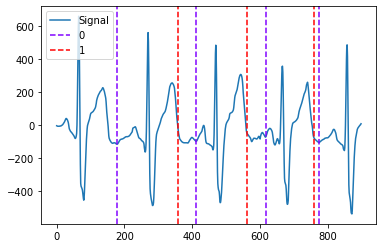

In [ ]:
_, waves_peak = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=300, method="peak")
# Zooming into the first 3 R-peaks, with focus on T_peaks, P-peaks, Q-peaks and S-peaks
plot = nk.events_plot([
                        waves_peak['ECG_P_Onsets'],
                        waves_peak['ECG_T_Offsets'],
                    ], ecg_signal[:1500])
print(waves_peak)


{'ECG_R_Peaks': array([270, 470, 666, 857]), 'sampling_rate': 300}
Index(['ECG_Raw', 'ECG_Clean', 'ECG_Rate', 'ECG_Quality', 'ECG_R_Peaks',
       'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks',
       'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks',
       'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial',
       'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
       'ECG_Phase_Completion_Ventricular'],
      dtype='object')


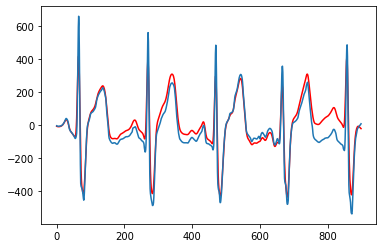

In [ ]:

signals, info = nk.ecg_process(ecg_signal, sampling_rate=300)

len(signals)
print(info)
print(signals.columns)




plt.figure()
plt.plot(signals['ECG_Clean'][:3000],c = 'r')
plt.plot(ecg_signal[:3000])
# plt.plot(signals['ECG_Quality'])

plt.show()
# print(r_peaks)